## 3. Model Fitting and Evaluation
To select the best model, we have tested various models on two outcome variables (Confirmed Cases and Deaths).  
3.1 : Outcome Variable - Confirmed Cases  
3.1.1 : Linear Models: Lasso, Ridge and Linear Regression  
3.1.2 : K - Fold cross Validation  
3.1.3 : Decision Tress Regression  
3.1.4 : Random Forest Regression  
3.1.5 : Conclusion  
3.2 : Outcome Variable - Deaths   
3.2.1 : Linear Models: Lasso, Ridge and Linear Regression  
3.2.2 : K - Fold cross Validation  
3.2.3 : Decision Tress Regression  
3.2.4 : Random Forest Regression  
3.2.5 : Conclusion  

## 4. Potential policy outcomes  
4.1 : predicting Deaths with the most strict vs most loose lockdown policy

In [1]:
# setting up the notebook
import pipeline
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### 3.1 : Outcome Variable - Confirmed Cases
#### 3.1.1 : Linear Models: Lasso, Ridge and Linear Regression

In [2]:
#setting up the dataframe 
filepath = '../data/covid_df_protocol_3.pkl'
df = pd.read_pickle(filepath)
df['log_cases'] = np.log(df['Confirmed Cases'] + 1)
# getting train and test dataframes
df_train, df_test = pipeline.split_and_scale_on_last_weeks(df, 2)
#sanity chceck
pipeline.sanity_check(df_train, df_test)
# Getting Features and outcome variables
X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')

Success: Features match
Success: No NAs remain


                           Feature  Coefficient
0                        Intercept        2.486
8             EconomicSupportIndex        0.170
19   Days Elapsed Since First Case        0.065
18                       Day Count        0.003
149            Country_Switzerland        0.000
..                             ...          ...
77                  Country_Guinea        0.000
78                   Country_Haiti       -0.000
79                Country_Honduras       -0.000
80                 Country_Hungary        0.000
215         H3_Contact tracing_2.0       -0.000

[216 rows x 2 columns]


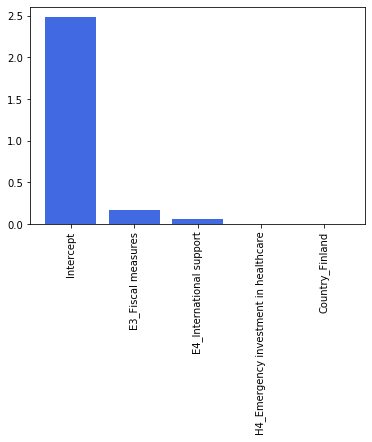

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        2.486
8             EconomicSupportIndex        0.170
19   Days Elapsed Since First Case        0.065
18                       Day Count        0.003
149            Country_Switzerland        0.000
139              Country_Singapore       -0.000
140        Country_Slovak Republic        0.000
141               Country_Slovenia        0.000
142           Country_South Africa        0.000
143            Country_South Korea        0.000

Bias: 2849425877.92
Root Mean squared error: 164190.72
RSS: 41004020172359.02
Variance score: -0.02

R2 score: 0.08

                       Feature  Coefficient
0                    Intercept        7.789
110           Country_Mongolia       -2.640
143        Country_South Korea       -2.539
84                Country_Iran        2.166
154        Country_Timor-Leste   

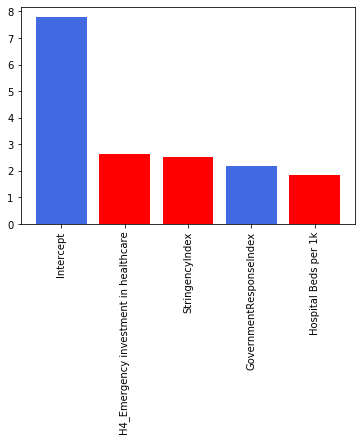

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept        7.789
110       Country_Mongolia       -2.640
143    Country_South Korea       -2.539
84            Country_Iran        2.166
154    Country_Timor-Leste       -1.844
88           Country_Italy        1.831
203  E1_Income support_2.0        1.787
114          Country_Nepal       -1.693
201  E1_Income support_0.0       -1.673
166        Country_Vietnam       -1.638

Bias: 2849394309.84
Root Mean squared error: 188761.96
RSS: 54194866677466.78
Variance score: -0.02

R2 score: -0.22

                       Feature  Coefficient
7       ContainmentHealthIndex     -756.408
5              StringencyIndex      424.611
6      GovernmentResponseIndex      295.593
212      H2_Testing policy_3.0       64.837
209      H2_Testing policy_0.0      -64.264
..                         ...          ...
13             Life Expectancy  

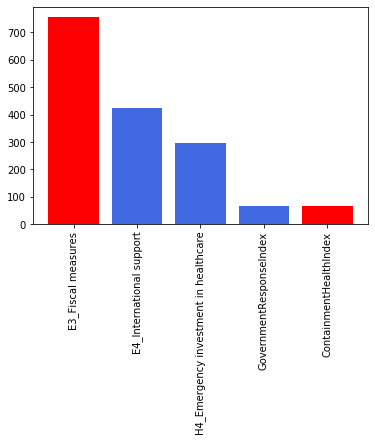

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
7     ContainmentHealthIndex     -756.408
5            StringencyIndex      424.611
6    GovernmentResponseIndex      295.593
212    H2_Testing policy_3.0       64.837
209    H2_Testing policy_0.0      -64.264
213   H3_Contact tracing_0.0      -64.236
215   H3_Contact tracing_2.0       64.036
0                  Intercept       50.549
8       EconomicSupportIndex      -42.113
210    H2_Testing policy_1.0      -21.880

Bias: 2849394316.39
Root Mean squared error: 197947.95
RSS: 59597940000766.59
Variance score: -0.02

R2 score: -0.34



In [3]:
# running Linear models 
results_dict = pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)

In [4]:
# comparing the metrics for all three models
rs = pd.DataFrame(results_dict) 
rs['metrics']= ['Bias','RMSE','RSS','Variance','R2']
rs = rs.set_index('metrics')
rs

,Lasso,Ridge,Linear Regression
metrics,,,
Bias,2849425877.923,2849394309.835,2849394316.385
RMSE,164190.722,188761.956,197947.954
RSS,41004020172359.023,54194866677466.781,59597940000766.586
Variance,-0.018,-0.018,-0.018
R2,0.075,-0.222,-0.344


In [5]:
## creating an evaluation matrix (RMSE values) for Confirmed Cases: 

Evalution_RMSE = rs[rs.index=="RMSE"].copy()
Evalution_RMSE['outcome'] = ['Confirmed Cases']
Evalution_RMSE = Evalution_RMSE.set_index('outcome')
Evalution_RMSE

,Lasso,Ridge,Linear Regression
outcome,,,
Confirmed Cases,164190.722,188761.956,197947.954


### 3.1.2 : K - Fold cross Validation

#### Time Series Nested Cross Validation

Time series Nested Cross Validation is carried out with the following approach: 

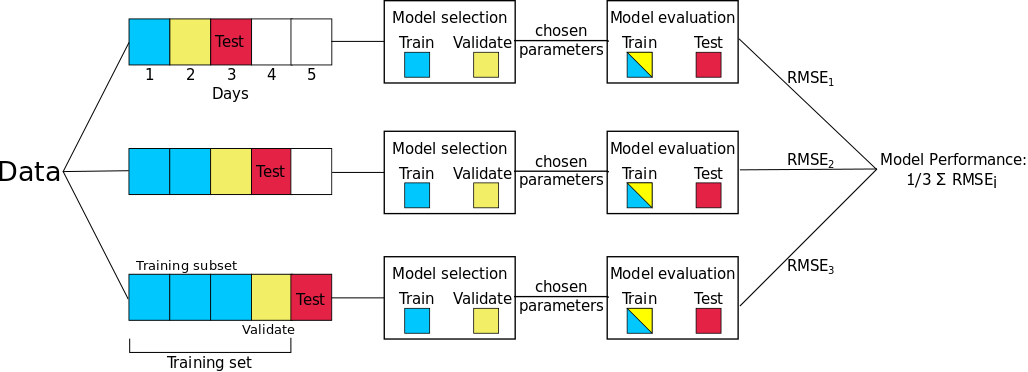

Cutting dataframe on date: 2020-06-02
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        2.486
8             EconomicSupportIndex        0.170
19   Days Elapsed Since First Case        0.065
18                       Day Count        0.003
149            Country_Switzerland        0.000
..                             ...          ...
77                  Country_Guinea        0.000
78                   Country_Haiti       -0.000
79                Country_Honduras       -0.000
80                 Country_Hungary        0.000
215         H3_Contact tracing_2.0       -0.000

[216 rows x 2 columns]


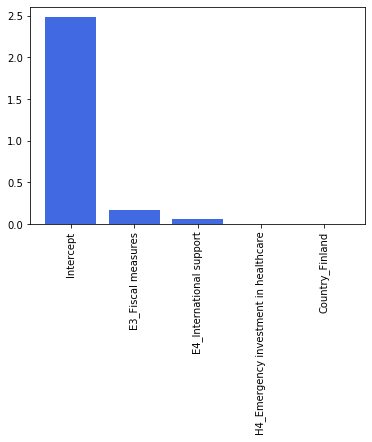

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        2.486
8             EconomicSupportIndex        0.170
19   Days Elapsed Since First Case        0.065
18                       Day Count        0.003
149            Country_Switzerland        0.000
139              Country_Singapore       -0.000
140        Country_Slovak Republic        0.000
141               Country_Slovenia        0.000
142           Country_South Africa        0.000
143            Country_South Korea        0.000

Bias: 2849425877.92
Root Mean squared error: 164190.72
RSS: 41004020172359.02
Variance score: -0.02

R2 score: 0.08

                       Feature  Coefficient
0                    Intercept        7.789
110           Country_Mongolia       -2.640
143        Country_South Korea       -2.539
84                Country_Iran        2.166
154        Country_Timor-Leste   

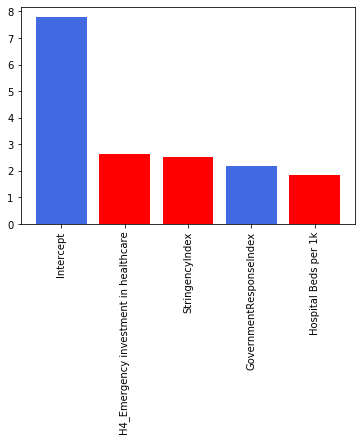

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept        7.789
110       Country_Mongolia       -2.640
143    Country_South Korea       -2.539
84            Country_Iran        2.166
154    Country_Timor-Leste       -1.844
88           Country_Italy        1.831
203  E1_Income support_2.0        1.787
114          Country_Nepal       -1.693
201  E1_Income support_0.0       -1.673
166        Country_Vietnam       -1.638

Bias: 2849394309.84
Root Mean squared error: 188761.96
RSS: 54194866677466.78
Variance score: -0.02

R2 score: -0.22

                       Feature  Coefficient
7       ContainmentHealthIndex     -756.408
5              StringencyIndex      424.611
6      GovernmentResponseIndex      295.593
212      H2_Testing policy_3.0       64.837
209      H2_Testing policy_0.0      -64.264
..                         ...          ...
13             Life Expectancy  

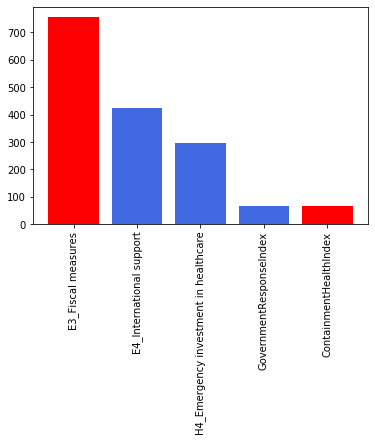

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
7     ContainmentHealthIndex     -756.408
5            StringencyIndex      424.611
6    GovernmentResponseIndex      295.593
212    H2_Testing policy_3.0       64.837
209    H2_Testing policy_0.0      -64.264
213   H3_Contact tracing_0.0      -64.236
215   H3_Contact tracing_2.0       64.036
0                  Intercept       50.549
8       EconomicSupportIndex      -42.113
210    H2_Testing policy_1.0      -21.880

Bias: 2849394316.39
Root Mean squared error: 197947.95
RSS: 59597940000766.59
Variance score: -0.02

R2 score: -0.34

Cutting dataframe on date: 2020-05-26
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        2.400
8             EconomicSupportIndex        0.215
19   Days Elapsed Since First Case        0.064
18                       Day 

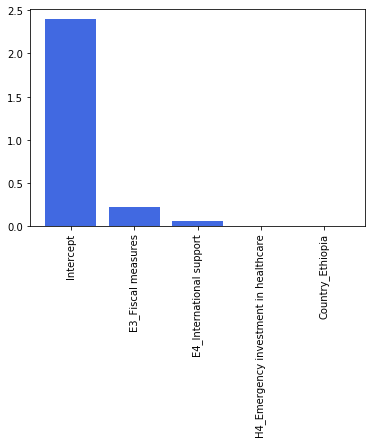

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        2.400
8             EconomicSupportIndex        0.215
19   Days Elapsed Since First Case        0.064
18                       Day Count        0.005
150                 Country_Sweden       -0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic        0.000
143               Country_Slovenia        0.000
144           Country_South Africa        0.000

Bias: 2091177956.63
Root Mean squared error: 132605.86
RSS: 36276439379126.35
Variance score: -0.02

R2 score: 0.05

                       Feature  Coefficient
0                    Intercept        7.894
85                Country_Iran        2.065
116              Country_Nepal       -1.959
205      E1_Income support_2.0        1.809
31             Country_Belarus   

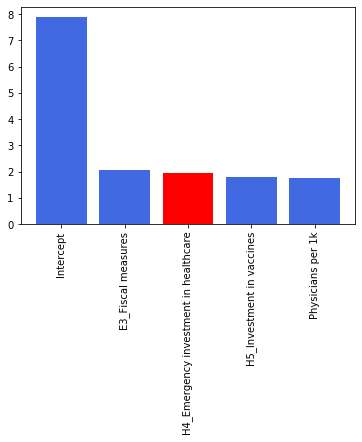

Ridge: Features with highest magnitude                                coefficients in absolute value
                         Feature  Coefficient
0                      Intercept        7.894
85                  Country_Iran        2.065
116                Country_Nepal       -1.959
205        E1_Income support_2.0        1.809
31               Country_Belarus        1.746
203        E1_Income support_0.0       -1.689
206  E2_Debt/contract relief_0.0       -1.531
112             Country_Mongolia       -1.471
168              Country_Vietnam       -1.438
83                 Country_India       -1.437

Bias: 2091150601.02
Root Mean squared error: 166830.59
RSS: 57418336002650.12
Variance score: -0.02

R2 score: -0.50

                                      Feature     Coefficient
0                                   Intercept 26265030876.604
195  C7_Restrictions on internal movement_0.0 -7438658802.540
197  C7_Restrictions on internal movement_2.0 -7438658801.370
196  C7_Restrictions on in

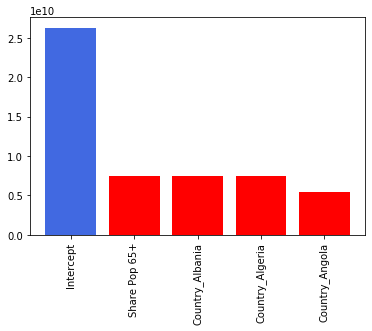

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                      Feature     Coefficient
0                                   Intercept 26265030876.604
195  C7_Restrictions on internal movement_0.0 -7438658802.540
197  C7_Restrictions on internal movement_2.0 -7438658801.370
196  C7_Restrictions on internal movement_1.0 -7438658801.318
172                     C1_School closing_0.0 -5478934996.300
175                     C1_School closing_3.0 -5478934994.649
174                     C1_School closing_2.0 -5478934994.616
173                     C1_School closing_1.0 -5478934994.085
203                     E1_Income support_0.0 -4143437537.658
204                     E1_Income support_1.0 -4143437536.060

Bias: 2091150538.86
Root Mean squared error: 172220.27
RSS: 61188214563059.72
Variance score: -0.02

R2 score: -0.60

Cutting dataframe on date: 2020-05-19
Success: Features match
Success: No NAs remain
 

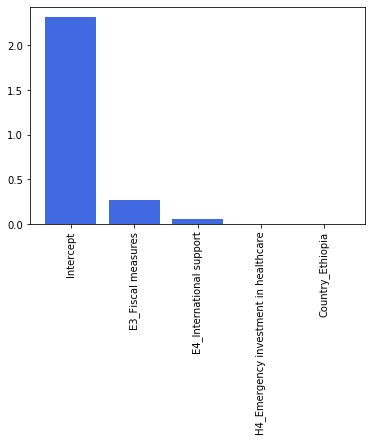

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        2.317
8             EconomicSupportIndex        0.267
19   Days Elapsed Since First Case        0.062
18                       Day Count        0.006
150                 Country_Sweden       -0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic        0.000
143               Country_Slovenia        0.000
144           Country_South Africa        0.000

Bias: 1452587543.82
Root Mean squared error: 118913.04
RSS: 29821914472246.09
Variance score: -0.02

R2 score: 0.03

                       Feature  Coefficient
0                    Intercept        8.252
85                Country_Iran        2.082
116              Country_Nepal       -1.859
205      E1_Income support_2.0        1.854
203      E1_Income support_0.0   

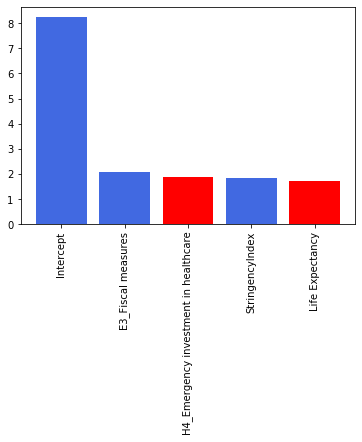

Ridge: Features with highest magnitude                                coefficients in absolute value
                         Feature  Coefficient
0                      Intercept        8.252
85                  Country_Iran        2.082
116                Country_Nepal       -1.859
205        E1_Income support_2.0        1.854
203        E1_Income support_0.0       -1.713
31               Country_Belarus        1.632
206  E2_Debt/contract relief_0.0       -1.499
112             Country_Mongolia       -1.455
83                 Country_India       -1.407
172        C1_School closing_0.0       -1.402

Bias: 1452564051.96
Root Mean squared error: 79424.46
RSS: 13304089306174.59
Variance score: -0.02

R2 score: 0.57

                       Feature  Coefficient
7       ContainmentHealthIndex     -637.860
5              StringencyIndex      550.045
214      H2_Testing policy_3.0       84.922
211      H2_Testing policy_0.0      -84.397
215     H3_Contact tracing_0.0      -84.333
..          

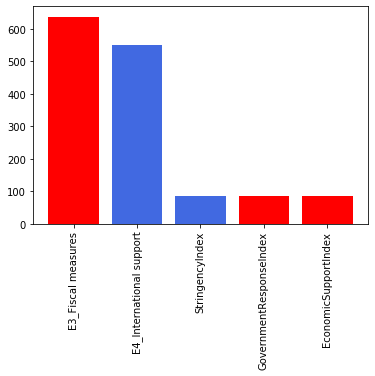

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
7     ContainmentHealthIndex     -637.860
5            StringencyIndex      550.045
214    H2_Testing policy_3.0       84.922
211    H2_Testing policy_0.0      -84.397
215   H3_Contact tracing_0.0      -84.333
217   H3_Contact tracing_2.0       84.153
0                  Intercept       75.483
212    H2_Testing policy_1.0      -28.563
213    H2_Testing policy_2.0       28.039
6    GovernmentResponseIndex        6.754

Bias: 1452563933.82
Root Mean squared error: 78182.81
RSS: 12891370091541.80
Variance score: -0.02

R2 score: 0.58

Cutting dataframe on date: 2020-05-12
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        2.231
8             EconomicSupportIndex        0.317
19   Days Elapsed Since First Case        0.059
18                       Day Co

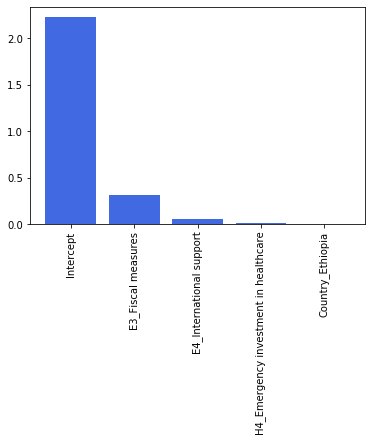

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        2.231
8             EconomicSupportIndex        0.317
19   Days Elapsed Since First Case        0.059
18                       Day Count        0.007
150                 Country_Sweden       -0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic        0.000
143               Country_Slovenia        0.000
144           Country_South Africa        0.000

Bias: 936944276.84
Root Mean squared error: 105923.93
RSS: 23561744697475.08
Variance score: -0.02

R2 score: 0.00

                       Feature  Coefficient
0                    Intercept        8.527
85                Country_Iran        2.068
205      E1_Income support_2.0        1.900
116              Country_Nepal       -1.740
203      E1_Income support_0.0    

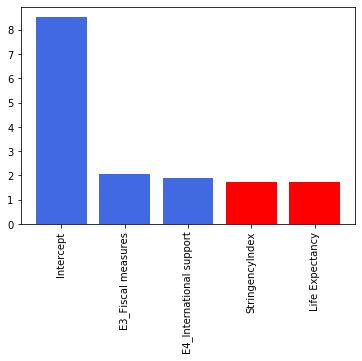

Ridge: Features with highest magnitude                                coefficients in absolute value
                         Feature  Coefficient
0                      Intercept        8.527
85                  Country_Iran        2.068
205        E1_Income support_2.0        1.900
116                Country_Nepal       -1.740
203        E1_Income support_0.0       -1.713
31               Country_Belarus        1.494
112             Country_Mongolia       -1.461
206  E2_Debt/contract relief_0.0       -1.454
172        C1_School closing_0.0       -1.416
83                 Country_India       -1.380

Bias: 936924609.51
Root Mean squared error: 67828.78
RSS: 9661560279221.93
Variance score: -0.02

R2 score: 0.59

                                   Feature     Coefficient
0                                Intercept -9674785731.069
182            C3_Cancel public events_2.0  6314511449.760
181            C3_Cancel public events_1.0  6314511448.823
180            C3_Cancel public events_0.0

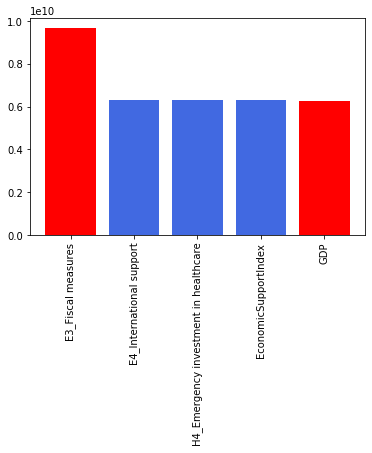

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                              Feature     Coefficient
0                           Intercept -9674785731.069
182       C3_Cancel public events_2.0  6314511449.760
181       C3_Cancel public events_1.0  6314511448.823
180       C3_Cancel public events_0.0  6314511448.177
191  C6_Stay at home requirements_0.0 -6282277945.004
192  C6_Stay at home requirements_1.0 -6282277944.447
193  C6_Stay at home requirements_2.0 -6282277943.852
194  C6_Stay at home requirements_3.0 -6282277943.435
205             E1_Income support_2.0  5290807827.846
204             E1_Income support_1.0  5290807825.761

Bias: 936924490.26
Root Mean squared error: 67720.50
RSS: 9630737817288.24
Variance score: -0.02

R2 score: 0.59

Cutting dataframe on date: 2020-05-05
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        2.1

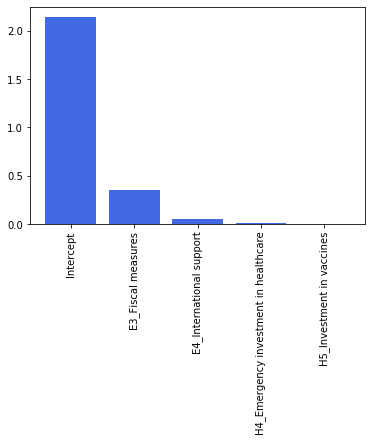

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        2.143
8             EconomicSupportIndex        0.347
19   Days Elapsed Since First Case        0.057
18                       Day Count        0.007
5                  StringencyIndex        0.001
150                 Country_Sweden       -0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic       -0.000
143               Country_Slovenia        0.000

Bias: 547357641.45
Root Mean squared error: 91335.98
RSS: 17527091484284.98
Variance score: -0.01

R2 score: -0.01

                          Feature  Coefficient
0                       Intercept        8.796
85                   Country_Iran        2.029
205         E1_Income support_2.0        1.955
203         E1_Income support_0.0       -1.714
116                

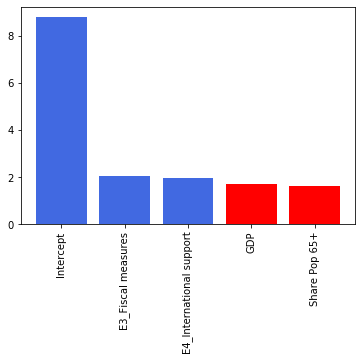

Ridge: Features with highest magnitude                                coefficients in absolute value
                         Feature  Coefficient
0                      Intercept        8.796
85                  Country_Iran        2.029
205        E1_Income support_2.0        1.955
203        E1_Income support_0.0       -1.714
116                Country_Nepal       -1.598
112             Country_Mongolia       -1.495
206  E2_Debt/contract relief_0.0       -1.480
172        C1_School closing_0.0       -1.412
83                 Country_India       -1.384
31               Country_Belarus        1.349

Bias: 547341832.09
Root Mean squared error: 63774.69
RSS: 8545209535585.97
Variance score: -0.01

R2 score: 0.51

                       Feature  Coefficient
7       ContainmentHealthIndex     -421.761
5              StringencyIndex      338.692
0                    Intercept       60.852
214      H2_Testing policy_3.0       55.614
211      H2_Testing policy_0.0      -55.221
..            

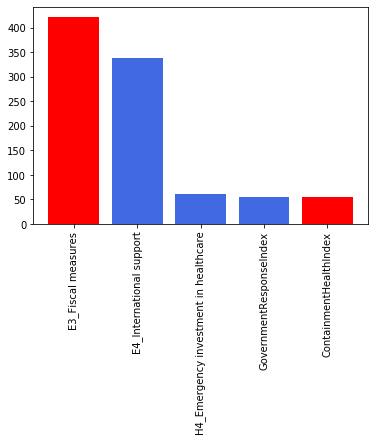

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
7     ContainmentHealthIndex     -421.761
5            StringencyIndex      338.692
0                  Intercept       60.852
214    H2_Testing policy_3.0       55.614
211    H2_Testing policy_0.0      -55.221
215   H3_Contact tracing_0.0      -55.176
217   H3_Contact tracing_2.0       55.046
6    GovernmentResponseIndex       34.447
212    H2_Testing policy_1.0      -18.789
213    H2_Testing policy_2.0       18.397

Bias: 547341735.24
Root Mean squared error: 63955.00
RSS: 8593597698438.25
Variance score: -0.01

R2 score: 0.50

Cutting dataframe on date: 2020-04-28
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        2.217
8             EconomicSupportIndex        0.309
5                  StringencyIndex        0.164
19   Days Elapsed Since First Cas

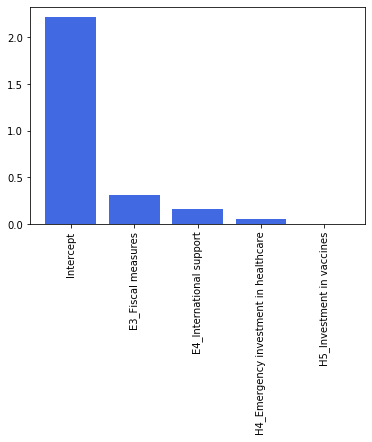

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        2.217
8             EconomicSupportIndex        0.309
5                  StringencyIndex        0.164
19   Days Elapsed Since First Case        0.053
18                       Day Count        0.004
151            Country_Switzerland        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic       -0.000
143               Country_Slovenia        0.000
144           Country_South Africa        0.000

Bias: 278197755.63
Root Mean squared error: 75494.88
RSS: 12042993512319.05
Variance score: -0.01

R2 score: -0.03

                         Feature  Coefficient
0                      Intercept        9.593
205        E1_Income support_2.0        2.064
85                  Country_Iran        1.972
203        E1_Income support_0.0       -1.771
206  E2_Debt/contract re

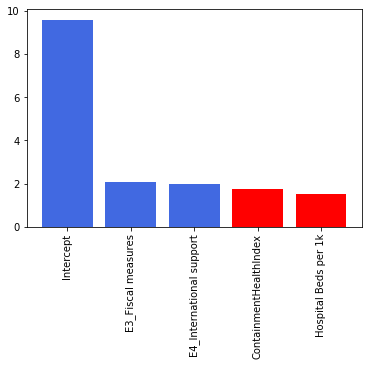

Ridge: Features with highest magnitude                                coefficients in absolute value
                         Feature  Coefficient
0                      Intercept        9.593
205        E1_Income support_2.0        2.064
85                  Country_Iran        1.972
203        E1_Income support_0.0       -1.771
206  E2_Debt/contract relief_0.0       -1.529
112             Country_Mongolia       -1.523
116                Country_Nepal       -1.473
208  E2_Debt/contract relief_2.0        1.418
83                 Country_India       -1.383
172        C1_School closing_0.0       -1.366

Bias: 278185450.78
Root Mean squared error: 55401.52
RSS: 6485491294195.35
Variance score: -0.01

R2 score: 0.45

                                   Feature      Coefficient
0                                Intercept  46617740770.226
164       Country_United States of America  18514603693.104
206            E2_Debt/contract relief_0.0 -18284784177.915
207            E2_Debt/contract relief

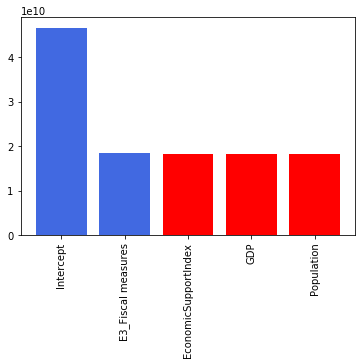

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                 Feature      Coefficient
0                              Intercept  46617740770.226
164     Country_United States of America  18514603693.104
206          E2_Debt/contract relief_0.0 -18284784177.915
207          E2_Debt/contract relief_1.0 -18284784176.241
208          E2_Debt/contract relief_2.0 -18284784174.886
216               H3_Contact tracing_0.0 -14707611351.323
217               H3_Contact tracing_1.0 -14707611313.356
218               H3_Contact tracing_2.0 -14707611275.667
211  H1_Public information campaigns_2.0  13586803850.429
210  H1_Public information campaigns_1.0  13586803849.879

Bias: 278185400.31
Root Mean squared error: 54969.77
RSS: 6384800569024.41
Variance score: -0.01

R2 score: 0.45

Cutting dataframe on date: 2020-04-21
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0

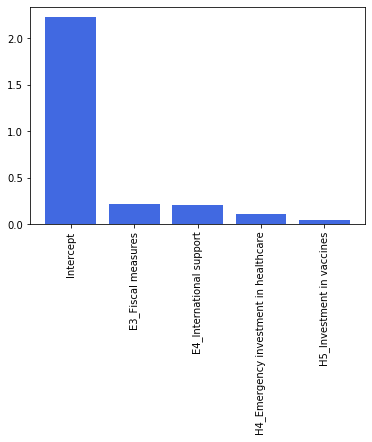

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        2.228
6          GovernmentResponseIndex        0.220
8             EconomicSupportIndex        0.209
5                  StringencyIndex        0.106
19   Days Elapsed Since First Case        0.049
18                       Day Count        0.000
142        Country_Slovak Republic       -0.000
143               Country_Slovenia        0.000
141              Country_Singapore        0.000
144           Country_South Africa        0.000

Bias: 117250559.63
Root Mean squared error: 58957.64
RSS: 7362174156314.90
Variance score: -0.01

R2 score: -0.04

                      Feature  Coefficient
0                   Intercept        9.871
205     E1_Income support_2.0        2.090
85               Country_Iran        1.882
203     E1_Income support_0.0       -1.708
112          Country_Mongolia       -1.6

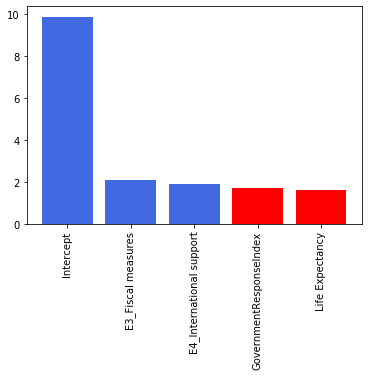

Ridge: Features with highest magnitude                                coefficients in absolute value
                         Feature  Coefficient
0                      Intercept        9.871
205        E1_Income support_2.0        2.090
85                  Country_Iran        1.882
203        E1_Income support_0.0       -1.708
112             Country_Mongolia       -1.605
206  E2_Debt/contract relief_0.0       -1.554
208  E2_Debt/contract relief_2.0        1.492
83                 Country_India       -1.345
172        C1_School closing_0.0       -1.308
116                Country_Nepal       -1.257

Bias: 117241580.13
Root Mean squared error: 42885.73
RSS: 3895395615096.66
Variance score: -0.01

R2 score: 0.45

                                   Feature     Coefficient
164       Country_United States of America -2099230319.820
0                                Intercept  1681894090.624
206            E2_Debt/contract relief_0.0 -1609433798.867
207            E2_Debt/contract relief_1.0

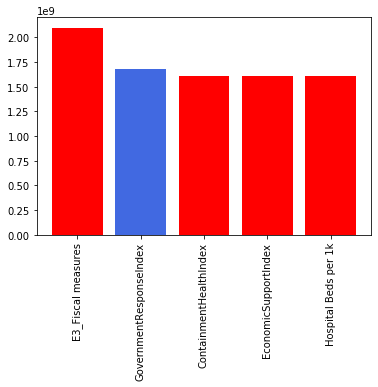

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                 Feature     Coefficient
164     Country_United States of America -2099230319.820
0                              Intercept  1681894090.624
206          E2_Debt/contract relief_0.0 -1609433798.867
207          E2_Debt/contract relief_1.0 -1609433797.204
208          E2_Debt/contract relief_2.0 -1609433795.699
50                         Country_China -1305997892.059
151                  Country_Switzerland  1198167998.241
83                         Country_India  1166482689.523
103                   Country_Luxembourg   945366271.892
209  H1_Public information campaigns_0.0  -870254269.776

Bias: 117241533.22
Root Mean squared error: 42847.58
RSS: 3888468676863.14
Variance score: -0.01

R2 score: 0.45



In [6]:
weeks_for_cv = [0,1,2,3,4,5,6]
n_weeks_prediction = 2
results = {}
for i in weeks_for_cv:
    shorter_df = pipeline.cut_df_on_weeks(df, i)
    df_train, df_test = pipeline.split_and_scale_on_last_weeks(shorter_df, n_weeks_prediction)
    pipeline.sanity_check(df_train, df_test)
    X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
    X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')
    dct = pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)
    results['Until week: ' +str(i)] = dct

In [7]:
# summarizing time seried nested Cross Validation: 

metrics_rmse = pd.DataFrame(columns=['Lasso','Ridge','Linear Regression'])
for i, mkey in enumerate(results):
    for key in results[mkey]:
        metrics_rmse.loc[i,key] = results[mkey][key][1]
metrics_rmse

,Lasso,Ridge,Linear Regression
0,164190.722,188761.956,197947.954
1,132605.859,166830.591,172220.274
2,118913.037,79424.463,78182.805
3,105923.928,67828.777,67720.496
4,91335.982,63774.686,63954.997
5,75494.876,55401.521,54969.770
6,58957.637,42885.730,42847.583


In [8]:
# finding averages across all folds

print("Lasso 7 fold avg:", metrics_rmse['Lasso'].mean())
print("Ridge 7 fold avg:", metrics_rmse['Ridge'].mean())
print("Linear Regression 7 fold avg:", metrics_rmse['Linear Regression'].mean() )

Lasso 7 fold avg: 106774.5770699611
Ridge 7 fold avg: 94986.8177695619
Linear Regression 7 fold avg: 96834.83990938491


In [9]:
Evalution_RMSE['Lasso_k_fold'] = metrics_rmse['Lasso'].mean()
Evalution_RMSE['Ridge_k_fold'] = metrics_rmse['Ridge'].mean()
Evalution_RMSE['LR_k_fold'] = metrics_rmse['Linear Regression'].mean()
Evalution_RMSE

,Lasso,Ridge,Linear Regression,Lasso_k_fold,Ridge_k_fold,LR_k_fold
outcome,,,,,,
Confirmed Cases,164190.722,188761.956,197947.954,106774.577,94986.818,96834.840


### 3.1.3 : Decision Tress Regression

In [10]:
## setting up Train and test dfs

## df for confirmed cases 
filepath = '../data/covid_df_protocol_3.pkl'
df = pd.read_pickle(filepath)
df['log_cases'] = df['Confirmed Cases']
df_train, df_test = pipeline.split_and_scale_on_last_weeks(df, 2)
pipeline.sanity_check(df_train, df_test)
X_train, y_train_cases = pipeline.divide_target_and_features(df_train, 'log_cases')
X_test, y_test_cases = pipeline.divide_target_and_features(df_test, 'log_cases')


Success: Features match
Success: No NAs remain


In [11]:
## fitting models

# on Confirmed Cases
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train_cases)
y_pred_cases = dtr.predict(X_test)
pipeline.metrics(y_pred_cases, y_test_cases, X_train, y_train_cases, dtr)

Bias: 0.00
Root Mean squared error: 25800.88
RSS: 1012507824100.00
Variance score: 1.00

R2 score: 0.98



(0.0, 25800.884043434406, 1012507824100.0, 1.0, 0.9771710639831147)

In [12]:
# making prediction and saving it to a pickle file
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_cases, y_test_cases)
predictions.to_pickle("../predictions/cases_dtr.pkl")

In [13]:
metrics = pipeline.metrics(y_pred_cases, y_test_cases, X_train, y_train_cases, dtr)
Evalution_RMSE['Decision Tree Regression'] = metrics[1]
Evalution_RMSE

Bias: 0.00
Root Mean squared error: 25800.88
RSS: 1012507824100.00
Variance score: 1.00

R2 score: 0.98



,Lasso,Ridge,Linear Regression,Lasso_k_fold,Ridge_k_fold,LR_k_fold,Decision Tree Regression
outcome,,,,,,,
Confirmed Cases,164190.722,188761.956,197947.954,106774.577,94986.818,96834.840,25800.884


### 3.1.4 : Random Forest Regression 

In [14]:
from sklearn.ensemble import RandomForestRegressor

# Confirmed Cases
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train_cases)
y_pred_cases = rf.predict(X_test)
metrics = pipeline.metrics(y_pred_cases, y_test_cases, X_train, y_train_cases, rf)

Bias: 176261.19
Root Mean squared error: 26285.32
RSS: 1050886654378.03
Variance score: 1.00

R2 score: 0.98



In [15]:
# making prediction and saving it to a pickle file
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_cases, y_test_cases)
predictions.to_pickle("../predictions/cases_rf.pkl")

In [16]:
Evalution_RMSE['Random Forest Regression'] = metrics[1]
Evalution_RMSE

,Lasso,Ridge,Linear Regression,Lasso_k_fold,Ridge_k_fold,LR_k_fold,Decision Tree Regression,Random Forest Regression
outcome,,,,,,,,
Confirmed Cases,164190.722,188761.956,197947.954,106774.577,94986.818,96834.840,25800.884,26285.324


### 3.1.5 : Conclusion 

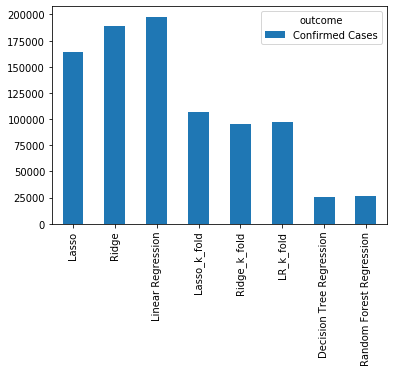

In [17]:
Evalution_RMSE.transpose().plot.bar()

From all the models, the Decision Tree Regression produces the lowest Root Mean Squared Error

## 3.2 : Outcome Variable - Deaths   
### 3.2.1 : Linear Models: Lasso, Ridge and Linear Regression  

In [18]:
#setting up the dataframe 
filepath = '../data/covid_df_protocol_3.pkl'
df = pd.read_pickle(filepath)
df['log_cases'] = np.log(df['Deaths'] + 1)
# getting train and test dataframes
df_train, df_test = pipeline.split_and_scale_on_last_weeks(df, 2)
#sanity chceck
pipeline.sanity_check(df_train, df_test)
# Getting Features and outcome variables
X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')

Success: Features match
Success: No NAs remain


                           Feature  Coefficient
0                        Intercept        1.170
19   Days Elapsed Since First Case        0.037
8             EconomicSupportIndex        0.015
18                       Day Count       -0.000
149            Country_Switzerland        0.000
..                             ...          ...
77                  Country_Guinea       -0.000
78                   Country_Haiti       -0.000
79                Country_Honduras        0.000
80                 Country_Hungary        0.000
215         H3_Contact tracing_2.0       -0.000

[216 rows x 2 columns]


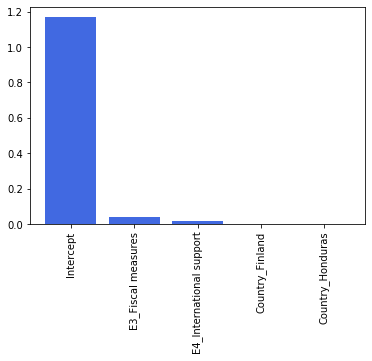

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        1.170
19   Days Elapsed Since First Case        0.037
8             EconomicSupportIndex        0.015
18                       Day Count       -0.000
149            Country_Switzerland        0.000
139              Country_Singapore       -0.000
140        Country_Slovak Republic       -0.000
141               Country_Slovenia        0.000
142           Country_South Africa        0.000
143            Country_South Korea        0.000

Bias: 13554673.41
Root Mean squared error: 11379.13
RSS: 196946104498.00
Variance score: -0.02

R2 score: -0.05

                      Feature  Coefficient
0                   Intercept        3.870
88              Country_Italy        2.395
84               Country_Iran        2.027
116       Country_New Zealand       -1.882
166           Country_Vietnam       -1.768

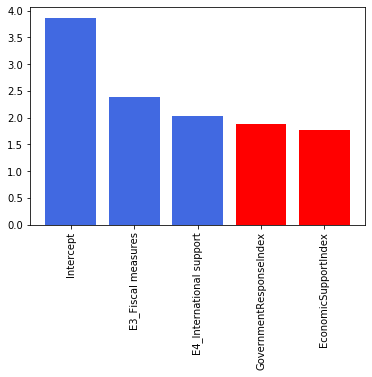

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept        3.870
88           Country_Italy        2.395
84            Country_Iran        2.027
116    Country_New Zealand       -1.882
166        Country_Vietnam       -1.768
81         Country_Iceland       -1.582
83       Country_Indonesia        1.509
82           Country_India       -1.445
144          Country_Spain        1.369
203  E1_Income support_2.0        1.355

Bias: 13551690.15
Root Mean squared error: 10371.99
RSS: 163626476419.75
Variance score: -0.02

R2 score: 0.13

                           Feature  Coefficient
7           ContainmentHealthIndex     -973.760
5                  StringencyIndex      904.163
212          H2_Testing policy_3.0      136.373
209          H2_Testing policy_0.0     -135.854
213         H3_Contact tracing_0.0     -135.512
..                             ...          ...
4        H

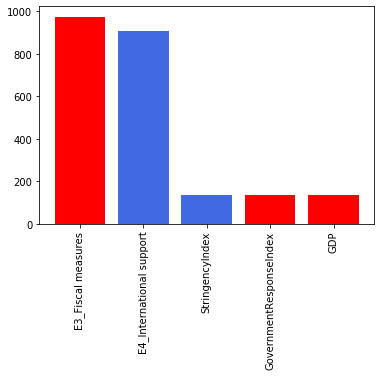

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
7     ContainmentHealthIndex     -973.760
5            StringencyIndex      904.163
212    H2_Testing policy_3.0      136.373
209    H2_Testing policy_0.0     -135.854
213   H3_Contact tracing_0.0     -135.512
215   H3_Contact tracing_2.0      135.400
0                  Intercept       93.981
6    GovernmentResponseIndex      -71.059
210    H2_Testing policy_1.0      -45.741
211    H2_Testing policy_2.0       45.223

Bias: 13551683.94
Root Mean squared error: 10326.61
RSS: 162197742901.85
Variance score: -0.02

R2 score: 0.14



In [19]:
# running Linear models 
results_dict = pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)

In [20]:
# comparing the metrics for all three models
rs = pd.DataFrame(results_dict) 
rs['metrics']= ['Bias','RMSE','RSS','Variance','R2']
rs = rs.set_index('metrics')
rs

,Lasso,Ridge,Linear Regression
metrics,,,
Bias,13554673.407,13551690.147,13551683.944
RMSE,11379.131,10371.992,10326.610
RSS,196946104498.001,163626476419.747,162197742901.852
Variance,-0.017,-0.017,-0.017
R2,-0.048,0.129,0.137


In [21]:
rmse_list = [rs.loc['RMSE','Lasso'], rs.loc['RMSE', 'Ridge'], rs.loc['RMSE','Linear Regression']]
Evalution_RMSE = Evalution_RMSE = Evalution_RMSE.append(dict(zip(Evalution_RMSE.columns,rmse_list)), 
                                                        ignore_index = True)
Evalution_RMSE['outcome'] = ['Confirmed Cases', 'Deaths']
Evalution_RMSE = Evalution_RMSE.set_index('outcome')
Evalution_RMSE

,Lasso,Ridge,Linear Regression,Lasso_k_fold,Ridge_k_fold,LR_k_fold,Decision Tree Regression,Random Forest Regression
outcome,,,,,,,,
Confirmed Cases,164190.722,188761.956,197947.954,106774.577,94986.818,96834.840,25800.884,26285.324
Deaths,11379.131,10371.992,10326.610,nan,nan,nan,nan,nan


### 3.2.2 : K - Fold cross Validation

Cutting dataframe on date: 2020-06-02
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        1.170
19   Days Elapsed Since First Case        0.037
8             EconomicSupportIndex        0.015
18                       Day Count       -0.000
149            Country_Switzerland        0.000
..                             ...          ...
77                  Country_Guinea       -0.000
78                   Country_Haiti       -0.000
79                Country_Honduras        0.000
80                 Country_Hungary        0.000
215         H3_Contact tracing_2.0       -0.000

[216 rows x 2 columns]


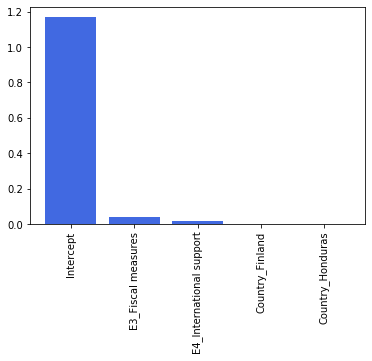

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        1.170
19   Days Elapsed Since First Case        0.037
8             EconomicSupportIndex        0.015
18                       Day Count       -0.000
149            Country_Switzerland        0.000
139              Country_Singapore       -0.000
140        Country_Slovak Republic       -0.000
141               Country_Slovenia        0.000
142           Country_South Africa        0.000
143            Country_South Korea        0.000

Bias: 13554673.41
Root Mean squared error: 11379.13
RSS: 196946104498.00
Variance score: -0.02

R2 score: -0.05

                      Feature  Coefficient
0                   Intercept        3.870
88              Country_Italy        2.395
84               Country_Iran        2.027
116       Country_New Zealand       -1.882
166           Country_Vietnam       -1.768

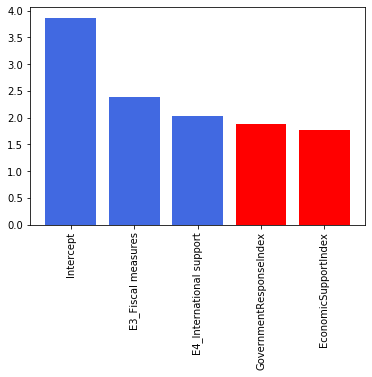

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept        3.870
88           Country_Italy        2.395
84            Country_Iran        2.027
116    Country_New Zealand       -1.882
166        Country_Vietnam       -1.768
81         Country_Iceland       -1.582
83       Country_Indonesia        1.509
82           Country_India       -1.445
144          Country_Spain        1.369
203  E1_Income support_2.0        1.355

Bias: 13551690.15
Root Mean squared error: 10371.99
RSS: 163626476419.75
Variance score: -0.02

R2 score: 0.13

                           Feature  Coefficient
7           ContainmentHealthIndex     -973.760
5                  StringencyIndex      904.163
212          H2_Testing policy_3.0      136.373
209          H2_Testing policy_0.0     -135.854
213         H3_Contact tracing_0.0     -135.512
..                             ...          ...
4        H

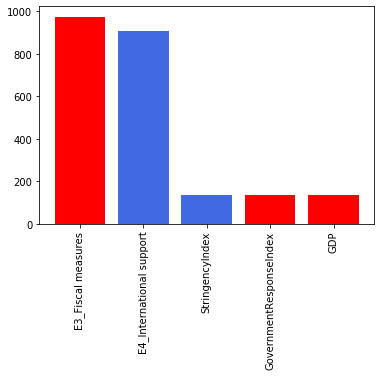

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
7     ContainmentHealthIndex     -973.760
5            StringencyIndex      904.163
212    H2_Testing policy_3.0      136.373
209    H2_Testing policy_0.0     -135.854
213   H3_Contact tracing_0.0     -135.512
215   H3_Contact tracing_2.0      135.400
0                  Intercept       93.981
6    GovernmentResponseIndex      -71.059
210    H2_Testing policy_1.0      -45.741
211    H2_Testing policy_2.0       45.223

Bias: 13551683.94
Root Mean squared error: 10326.61
RSS: 162197742901.85
Variance score: -0.02

R2 score: 0.14

Cutting dataframe on date: 2020-05-26
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        1.153
8             EconomicSupportIndex        0.044
19   Days Elapsed Since First Case        0.036
150                 Country_Sweden 

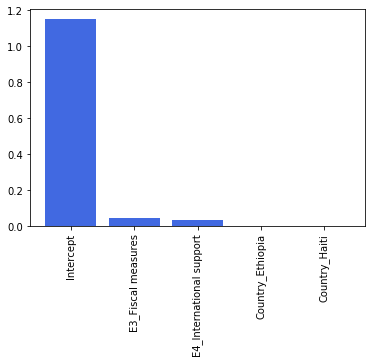

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        1.153
8             EconomicSupportIndex        0.044
19   Days Elapsed Since First Case        0.036
150                 Country_Sweden        0.000
139             Country_Seychelles       -0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic       -0.000
143               Country_Slovenia        0.000
144           Country_South Africa        0.000

Bias: 10006818.39
Root Mean squared error: 9381.05
RSS: 181552380857.62
Variance score: -0.02

R2 score: -0.05

                                        Feature  Coefficient
0                                     Intercept        4.046
89                                Country_Italy        2.354
85                                 Country_Iran        2.045
118           

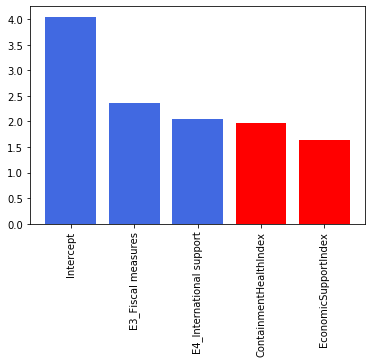

Ridge: Features with highest magnitude                                coefficients in absolute value
                   Feature  Coefficient
0                Intercept        4.046
89           Country_Italy        2.354
85            Country_Iran        2.045
118    Country_New Zealand       -1.977
168        Country_Vietnam       -1.632
83           Country_India       -1.551
82         Country_Iceland       -1.449
146          Country_Spain        1.369
84       Country_Indonesia        1.330
205  E1_Income support_2.0        1.310

Bias: 10004340.95
Root Mean squared error: 8977.89
RSS: 166282893443.88
Variance score: -0.02

R2 score: 0.04

                                      Feature     Coefficient
0                                   Intercept  6053843542.067
195  C7_Restrictions on internal movement_0.0 -1714541136.023
197  C7_Restrictions on internal movement_2.0 -1714541134.860
196  C7_Restrictions on internal movement_1.0 -1714541134.784
172                     C1_School clo

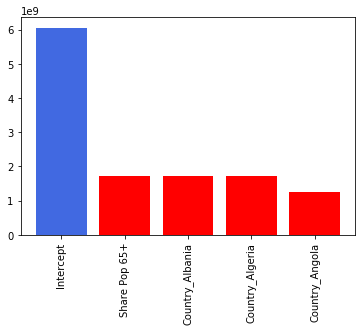

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                      Feature     Coefficient
0                                   Intercept  6053843542.067
195  C7_Restrictions on internal movement_0.0 -1714541136.023
197  C7_Restrictions on internal movement_2.0 -1714541134.860
196  C7_Restrictions on internal movement_1.0 -1714541134.784
172                     C1_School closing_0.0 -1262843166.101
175                     C1_School closing_3.0 -1262843165.157
174                     C1_School closing_2.0 -1262843164.905
173                     C1_School closing_1.0 -1262843164.611
203                     E1_Income support_0.0  -955023519.032
204                     E1_Income support_1.0  -955023517.869

Bias: 10004331.96
Root Mean squared error: 8900.04
RSS: 163411595084.91
Variance score: -0.02

R2 score: 0.06

Cutting dataframe on date: 2020-05-19
Success: Features match
Success: No NAs remain
        

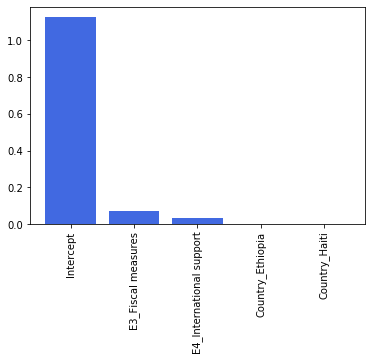

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        1.128
8             EconomicSupportIndex        0.073
19   Days Elapsed Since First Case        0.034
150                 Country_Sweden        0.000
139             Country_Seychelles       -0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic       -0.000
143               Country_Slovenia        0.000
144           Country_South Africa        0.000

Bias: 6907946.44
Root Mean squared error: 8515.92
RSS: 152946490065.82
Variance score: -0.01

R2 score: -0.05

                           Feature  Coefficient
0                        Intercept        4.262
89                   Country_Italy        2.250
85                    Country_Iran        2.068
118            Country_New Zealand       -1.888
168                

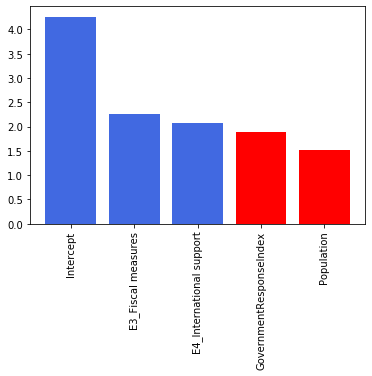

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept        4.262
89                      Country_Italy        2.250
85                       Country_Iran        2.068
118               Country_New Zealand       -1.888
168                   Country_Vietnam       -1.525
83                      Country_India       -1.517
205             E1_Income support_2.0        1.339
164  Country_United States of America       -1.276
82                    Country_Iceland       -1.274
203             E1_Income support_0.0       -1.259

Bias: 6905941.95
Root Mean squared error: 7690.73
RSS: 124741572267.97
Variance score: -0.01

R2 score: 0.15

                      Feature  Coefficient
5             StringencyIndex      997.327
7      ContainmentHealthIndex     -873.618
6     GovernmentResponseIndex     -295.305
214     H2_Testing policy_3.0      152.636
211     H2_T

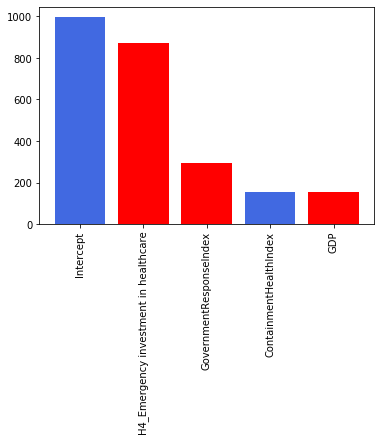

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
5            StringencyIndex      997.327
7     ContainmentHealthIndex     -873.618
6    GovernmentResponseIndex     -295.305
214    H2_Testing policy_3.0      152.636
211    H2_Testing policy_0.0     -152.143
215   H3_Contact tracing_0.0     -151.796
217   H3_Contact tracing_2.0      151.664
0                  Intercept      125.257
212    H2_Testing policy_1.0      -51.138
213    H2_Testing policy_2.0       50.645

Bias: 6905929.53
Root Mean squared error: 7675.78
RSS: 124257252223.56
Variance score: -0.01

R2 score: 0.15

Cutting dataframe on date: 2020-05-12
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        1.081
8             EconomicSupportIndex        0.090
19   Days Elapsed Since First Case        0.032
150                 Country_Sweden   

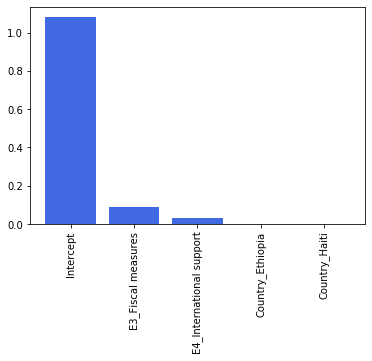

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        1.081
8             EconomicSupportIndex        0.090
19   Days Elapsed Since First Case        0.032
150                 Country_Sweden        0.000
139             Country_Seychelles       -0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic       -0.000
143               Country_Slovenia        0.000
144           Country_South Africa       -0.000

Bias: 4363044.90
Root Mean squared error: 7590.00
RSS: 120976967222.15
Variance score: -0.01

R2 score: -0.05

                       Feature  Coefficient
0                    Intercept        4.410
89               Country_Italy        2.108
85                Country_Iran        2.057
118        Country_New Zealand       -1.825
83               Country_India       -1

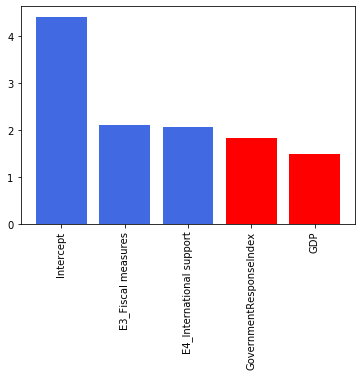

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept        4.410
89                      Country_Italy        2.108
85                       Country_Iran        2.057
118               Country_New Zealand       -1.825
83                      Country_India       -1.492
168                   Country_Vietnam       -1.413
205             E1_Income support_2.0        1.369
203             E1_Income support_0.0       -1.273
164  Country_United States of America       -1.249
146                     Country_Spain        1.178

Bias: 4361492.85
Root Mean squared error: 6988.36
RSS: 102558082301.91
Variance score: -0.01

R2 score: 0.11

                                   Feature     Coefficient
0                                Intercept -6215614544.237
182            C3_Cancel public events_2.0  4056789560.141
181            C3_Cancel public events_1.0  405678

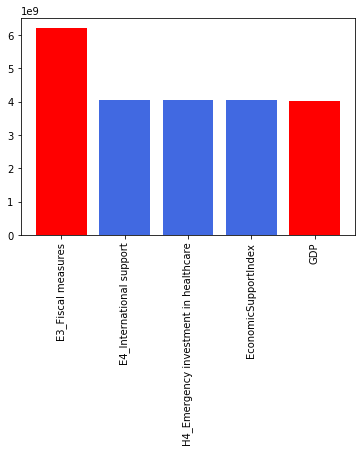

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                              Feature     Coefficient
0                           Intercept -6215614544.237
182       C3_Cancel public events_2.0  4056789560.141
181       C3_Cancel public events_1.0  4056789559.773
180       C3_Cancel public events_0.0  4056789559.587
191  C6_Stay at home requirements_0.0 -4036080983.595
192  C6_Stay at home requirements_1.0 -4036080983.276
194  C6_Stay at home requirements_3.0 -4036080982.609
193  C6_Stay at home requirements_2.0 -4036080982.533
205             E1_Income support_2.0  3399106032.742
204             E1_Income support_1.0  3399106031.319

Bias: 4361481.08
Root Mean squared error: 6971.82
RSS: 102073280159.65
Variance score: -0.01

R2 score: 0.11

Cutting dataframe on date: 2020-05-05
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        0.981
8

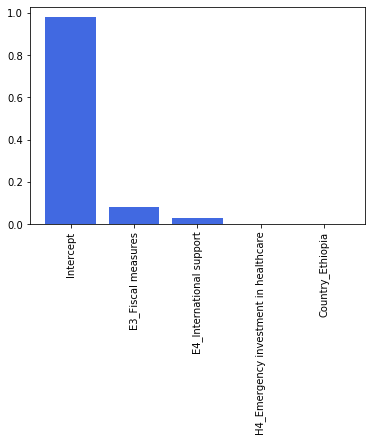

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        0.981
8             EconomicSupportIndex        0.079
19   Days Elapsed Since First Case        0.028
18                       Day Count        0.000
150                 Country_Sweden        0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic       -0.000
143               Country_Slovenia        0.000
144           Country_South Africa       -0.000

Bias: 2421590.65
Root Mean squared error: 6523.79
RSS: 89418314669.71
Variance score: -0.01

R2 score: -0.05

                      Feature  Coefficient
0                   Intercept        4.509
85               Country_Iran        2.031
89              Country_Italy        1.953
118       Country_New Zealand       -1.761
83              Country_India       -1.484
..

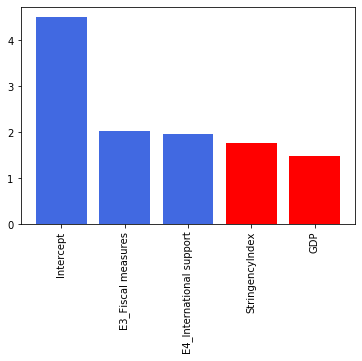

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept        4.509
85                       Country_Iran        2.031
89                      Country_Italy        1.953
118               Country_New Zealand       -1.761
83                      Country_India       -1.484
205             E1_Income support_2.0        1.384
168                   Country_Vietnam       -1.291
203             E1_Income support_0.0       -1.247
164  Country_United States of America       -1.223
146                     Country_Spain        1.082

Bias: 2420461.67
Root Mean squared error: 6131.04
RSS: 78975763101.35
Variance score: -0.01

R2 score: 0.07

                       Feature  Coefficient
5              StringencyIndex      750.559
7       ContainmentHealthIndex     -602.119
6      GovernmentResponseIndex     -280.782
214      H2_Testing policy_3.0      121.624
211     

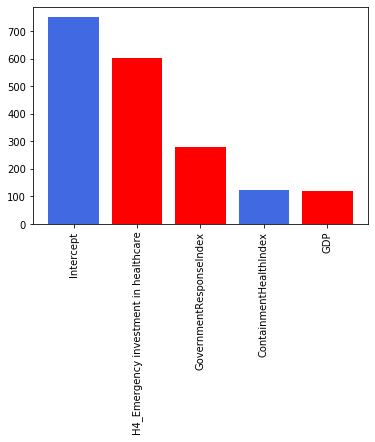

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                     Feature  Coefficient
5            StringencyIndex      750.559
7     ContainmentHealthIndex     -602.119
6    GovernmentResponseIndex     -280.782
214    H2_Testing policy_3.0      121.624
211    H2_Testing policy_0.0     -121.184
215   H3_Contact tracing_0.0     -120.850
217   H3_Contact tracing_2.0      120.738
0                  Intercept      118.794
212    H2_Testing policy_1.0      -40.772
213    H2_Testing policy_2.0       40.333

Bias: 2420453.74
Root Mean squared error: 6119.99
RSS: 78691319566.02
Variance score: -0.01

R2 score: 0.07

Cutting dataframe on date: 2020-04-28
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0                        Intercept        0.869
8             EconomicSupportIndex        0.037
19   Days Elapsed Since First Case        0.025
18                       Day Count    

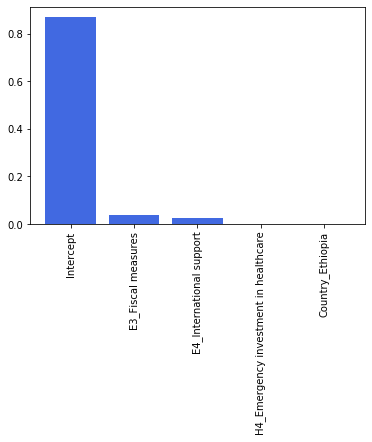

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        0.869
8             EconomicSupportIndex        0.037
19   Days Elapsed Since First Case        0.025
18                       Day Count        0.001
150                 Country_Sweden       -0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic       -0.000
143               Country_Slovenia        0.000
144           Country_South Africa       -0.000

Bias: 1118372.77
Root Mean squared error: 5330.41
RSS: 60037256368.58
Variance score: -0.01

R2 score: -0.05

                 Feature  Coefficient
0              Intercept        4.874
85          Country_Iran        1.965
89         Country_Italy        1.770
118  Country_New Zealand       -1.642
83         Country_India       -1.451
..                   ...        

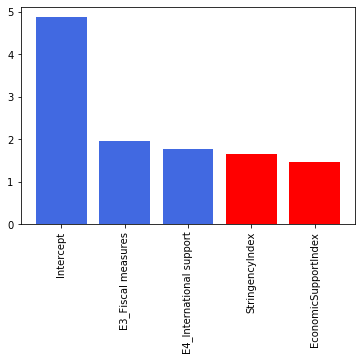

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept        4.874
85                       Country_Iran        1.965
89                      Country_Italy        1.770
118               Country_New Zealand       -1.642
83                      Country_India       -1.451
205             E1_Income support_2.0        1.376
203             E1_Income support_0.0       -1.192
164  Country_United States of America       -1.184
50                      Country_China        1.160
168                   Country_Vietnam       -1.118

Bias: 1117613.30
Root Mean squared error: 5087.66
RSS: 54693440380.59
Variance score: -0.01

R2 score: 0.04

                                   Feature      Coefficient
0                                Intercept  37878717510.283
164       Country_United States of America  15043831604.722
206            E2_Debt/contract relief_0.0 -1485

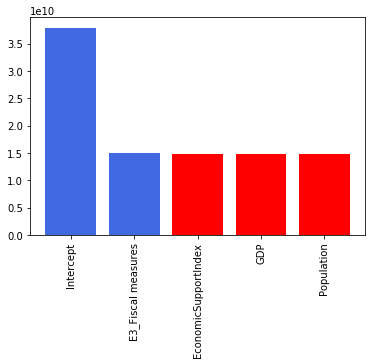

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                 Feature      Coefficient
0                              Intercept  37878717510.283
164     Country_United States of America  15043831604.722
206          E2_Debt/contract relief_0.0 -14857094359.377
207          E2_Debt/contract relief_1.0 -14857094358.748
208          E2_Debt/contract relief_2.0 -14857094358.413
216               H3_Contact tracing_0.0 -11950503144.087
217               H3_Contact tracing_1.0 -11950503050.406
218               H3_Contact tracing_2.0 -11950502957.001
211  H1_Public information campaigns_2.0  11039803636.288
210  H1_Public information campaigns_1.0  11039803636.075

Bias: 1117608.13
Root Mean squared error: 5082.60
RSS: 54584855570.83
Variance score: -0.01

R2 score: 0.04

Cutting dataframe on date: 2020-04-21
Success: Features match
Success: No NAs remain
                           Feature  Coefficient
0     

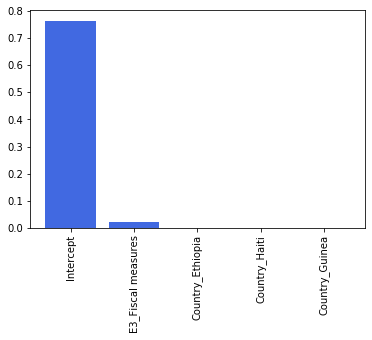

Lasso: Features with highest magnitude                                coefficients in absolute value
                           Feature  Coefficient
0                        Intercept        0.765
19   Days Elapsed Since First Case        0.021
137                Country_Senegal       -0.000
139             Country_Seychelles       -0.000
140           Country_Sierra Leone        0.000
141              Country_Singapore       -0.000
142        Country_Slovak Republic       -0.000
143               Country_Slovenia        0.000
144           Country_South Africa       -0.000
145            Country_South Korea        0.000

Bias: 415629.94
Root Mean squared error: 4033.35
RSS: 34455473669.12
Variance score: -0.01

R2 score: -0.05

                              Feature  Coefficient
0                           Intercept        4.704
85                       Country_Iran        1.868
89                      Country_Italy        1.560
83                      Country_India       -1.388
118   

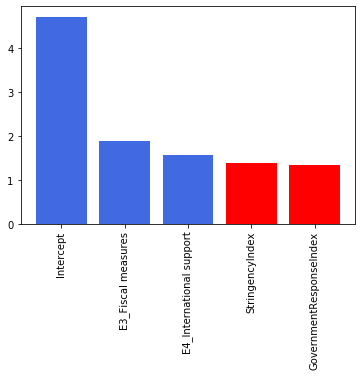

Ridge: Features with highest magnitude                                coefficients in absolute value
                              Feature  Coefficient
0                           Intercept        4.704
85                       Country_Iran        1.868
89                      Country_Italy        1.560
83                      Country_India       -1.388
118               Country_New Zealand       -1.330
205             E1_Income support_2.0        1.294
50                      Country_China        1.237
164  Country_United States of America       -1.122
203             E1_Income support_0.0       -1.043
168                   Country_Vietnam       -0.969

Bias: 415171.35
Root Mean squared error: 3898.24
RSS: 32185723637.23
Variance score: -0.01

R2 score: 0.02

                                   Feature     Coefficient
164       Country_United States of America  3285722161.676
0                                Intercept -2632505939.206
208            E2_Debt/contract relief_2.0  25190910

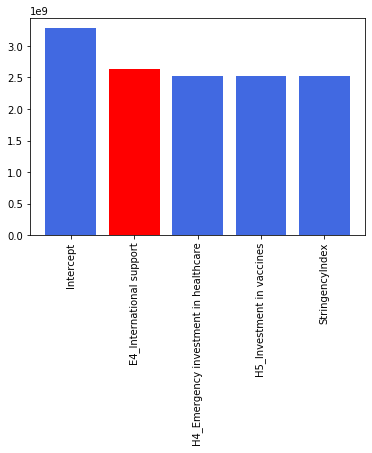

Linear Regression: Features with highest magnitude                                coefficients in absolute value
                                 Feature     Coefficient
164     Country_United States of America  3285722161.676
0                              Intercept -2632505939.206
208          E2_Debt/contract relief_2.0  2519091045.613
207          E2_Debt/contract relief_1.0  2519091045.265
206          E2_Debt/contract relief_0.0  2519091044.850
50                         Country_China  2044152176.318
151                  Country_Switzerland -1875376471.408
83                         Country_India -1825782525.928
103                   Country_Luxembourg -1479690383.812
211  H1_Public information campaigns_2.0  1362124830.014

Bias: 415166.10
Root Mean squared error: 3900.86
RSS: 32228966658.73
Variance score: -0.01

R2 score: 0.02



In [22]:
weeks_for_cv = [0,1,2,3,4,5,6]
n_weeks_prediction = 2
results = {}
for i in weeks_for_cv:
    shorter_df = pipeline.cut_df_on_weeks(df, i)
    df_train, df_test = pipeline.split_and_scale_on_last_weeks(shorter_df, n_weeks_prediction)
    pipeline.sanity_check(df_train, df_test)
    X_train, y_train = pipeline.divide_target_and_features(df_train, 'log_cases')
    X_test, y_test = pipeline.divide_target_and_features(df_test, 'log_cases')
    dct = pipeline.train_and_evaluate(X_train, y_train, X_test, y_test)
    results['Until week: ' +str(i)] = dct

In [23]:
# summarizing time seried nested Cross Validation: 

metrics_rmse = pd.DataFrame(columns=['Lasso','Ridge','Linear Regression'])
for i, mkey in enumerate(results):
    for key in results[mkey]:
        metrics_rmse.loc[i,key] = results[mkey][key][1]
metrics_rmse

,Lasso,Ridge,Linear Regression
0,11379.131,10371.992,10326.610
1,9381.048,8977.888,8900.037
2,8515.918,7690.726,7675.781
3,7589.999,6988.360,6971.824
4,6523.794,6131.036,6119.985
5,5330.411,5087.658,5082.605
6,4033.352,3898.241,3900.859


In [24]:
Evalution_RMSE.loc['Deaths','Lasso_k_fold'] = metrics_rmse['Lasso'].mean()
Evalution_RMSE.loc['Deaths','Ridge_k_fold'] = metrics_rmse['Ridge'].mean()
Evalution_RMSE.loc['Deaths','LR_k_fold'] = metrics_rmse['Linear Regression'].mean()
Evalution_RMSE

,Lasso,Ridge,Linear Regression,Lasso_k_fold,Ridge_k_fold,LR_k_fold,Decision Tree Regression,Random Forest Regression
outcome,,,,,,,,
Confirmed Cases,164190.722,188761.956,197947.954,106774.577,94986.818,96834.840,25800.884,26285.324
Deaths,11379.131,10371.992,10326.610,7536.236,7020.843,6996.814,nan,nan


### 3.2.3 : Decision Tress Regression

In [25]:
## df for deaths
df = pd.read_pickle(filepath)
df['log_cases'] = df['Deaths']
df_train, df_test = pipeline.split_and_scale_on_last_weeks(df, 2)
pipeline.sanity_check(df_train, df_test)
X_train, y_train_deaths = pipeline.divide_target_and_features(df_train, 'log_cases')
X_test, y_test_deaths = pipeline.divide_target_and_features(df_test, 'log_cases')

Success: Features match
Success: No NAs remain


In [26]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train_deaths)
y_pred_deaths = dtr.predict(X_test)
pipeline.metrics(y_pred_deaths, y_test_deaths, X_train, y_train_deaths, dtr)

Bias: 0.00
Root Mean squared error: 2993.15
RSS: 13626554860.00
Variance score: 1.00

R2 score: 0.93



(0.0, 2993.149625583532, 13626554860.0, 1.0, 0.9274650554857545)

In [27]:
# making prediction and saving it to a pickle file
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_deaths, y_test_deaths)
predictions.to_pickle("../predictions/deaths_dtr.pkl")

In [28]:
metrics = pipeline.metrics(y_pred_deaths, y_test_deaths, X_train, y_train_deaths, dtr)
Evalution_RMSE.loc['Deaths','Decision Tree Regression'] = metrics[1]
Evalution_RMSE

Bias: 0.00
Root Mean squared error: 2993.15
RSS: 13626554860.00
Variance score: 1.00

R2 score: 0.93



,Lasso,Ridge,Linear Regression,Lasso_k_fold,Ridge_k_fold,LR_k_fold,Decision Tree Regression,Random Forest Regression
outcome,,,,,,,,
Confirmed Cases,164190.722,188761.956,197947.954,106774.577,94986.818,96834.840,25800.884,26285.324
Deaths,11379.131,10371.992,10326.610,7536.236,7020.843,6996.814,2993.150,nan


### 3.1.4 : Random Forest Regression 

In [29]:
# Deaths
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train_deaths)
y_pred_deaths = rf.predict(X_test)
metrics = pipeline.metrics(y_pred_deaths, y_test_deaths, X_train, y_train_deaths, rf)

Bias: 1220.88
Root Mean squared error: 2075.76
RSS: 6553678642.38
Variance score: 1.00

R2 score: 0.97



In [30]:
# making prediction and saving it to a pickle file
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_deaths, y_test_deaths)
predictions.to_pickle("../predictions/deaths_rf.pkl")

In [31]:
Evalution_RMSE.loc['Deaths','Random Forest Regression'] = metrics[1]
Evalution_RMSE

,Lasso,Ridge,Linear Regression,Lasso_k_fold,Ridge_k_fold,LR_k_fold,Decision Tree Regression,Random Forest Regression
outcome,,,,,,,,
Confirmed Cases,164190.722,188761.956,197947.954,106774.577,94986.818,96834.840,25800.884,26285.324
Deaths,11379.131,10371.992,10326.610,7536.236,7020.843,6996.814,2993.150,2075.764


### 3.2.5 : Conclusion 

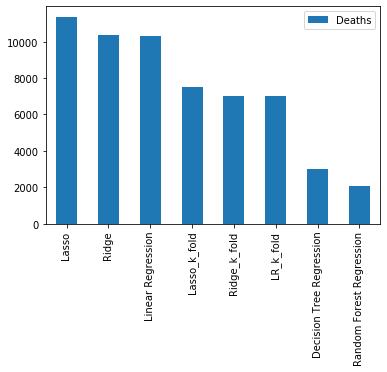

In [32]:
Evalution_RMSE.transpose().plot.bar(y='Deaths')

In [33]:
Evalution_RMSE.to_pickle("../predictions/Evaluation_RMSE.pkl")

- Random Forest has the lowest RMSE. 

## 4. Potential policy outcomes  
### 4.1 : predicting Deaths with the most strict vs most loose lockdown policy

In [34]:
# important features
features = pd.DataFrame({'feature': X_train.columns,
             'feature_importance': rf.feature_importances_})
features = features.set_index('feature')
#features.plot(kind='bar')
pd.options.display.max_rows = None
features.sort_values('feature_importance', ascending=False).head(10)

,feature_importance
feature,
Days Elapsed Since First Case,0.237
GDP,0.179
Country_United States of America,0.114
Day Count,0.111
Diabetes Prevalence,0.110
"Current Health Expenditure Per Capita, PPP",0.105
Country_Spain,0.064
Population,0.019
Country_Italy,0.009


In [35]:
# Scenario 1: Really strict lockdown
# Making a really strict lockdown policy in all measures

# preparing a test dataset assuming a very strict policy 
# school closing 
X_test.loc[:,'C1_School closing_0.0'] = 0 
X_test.loc[:,'C1_School closing_1.0'] = 0 
X_test.loc[:,'C1_School closing_2.0'] = 0
X_test.loc[:,'C1_School closing_3.0'] = 1
#
X_test.loc[:,'C2_Workplace closing_0.0'] = 0
X_test.loc[:,'C2_Workplace closing_1.0'] = 0
X_test.loc[:,'C2_Workplace closing_2.0'] = 0
X_test.loc[:,'C2_Workplace closing_3.0'] = 1
#
X_test.loc[:,'C3_Cancel public events_0.0'] = 0
X_test.loc[:,'C3_Cancel public events_1.0'] = 0
X_test.loc[:,'C3_Cancel public events_2.0'] = 1
#
X_test.loc[:,'C4_Restrictions on gatherings_0.0'] = 0
X_test.loc[:,'C4_Restrictions on gatherings_1.0'] = 0
X_test.loc[:,'C4_Restrictions on gatherings_2.0'] = 0
X_test.loc[:,'C4_Restrictions on gatherings_3.0'] = 0
X_test.loc[:,'C4_Restrictions on gatherings_4.0'] = 1
#
X_test.loc[:,'C5_Close public transport_0.0'] = 0
X_test.loc[:,'C5_Close public transport_1.0'] = 0
X_test.loc[:,'C5_Close public transport_2.0'] = 1
#
X_test.loc[:,'C6_Stay at home requirements_0.0'] = 0
X_test.loc[:,'C6_Stay at home requirements_1.0'] = 0
X_test.loc[:,'C6_Stay at home requirements_2.0'] = 0
X_test.loc[:,'C6_Stay at home requirements_3.0'] = 1
#
X_test.loc[:,'C7_Restrictions on internal movement_0.0'] = 0
X_test.loc[:,'C7_Restrictions on internal movement_1.0'] = 0
X_test.loc[:,'C7_Restrictions on internal movement_2.0'] = 1
#
X_test.loc[:,'C8_International travel controls_0.0'] = 0
X_test.loc[:,'C8_International travel controls_1.0'] = 0
X_test.loc[:,'C8_International travel controls_2.0'] = 0
X_test.loc[:,'C8_International travel controls_3.0'] = 0
X_test.loc[:,'C8_International travel controls_4.0'] = 1
#
X_test.loc[:,'StringencyIndex'] = 100
X_test.loc[:,'GovernmentResponseIndex'] = 100 
X_test.loc[:,'ContainmentHealthIndex'] = 100
X_test.loc[:,'EconomicSupportIndex'] = 100

# prediction
y_pred_deaths = rf.predict(X_test)

#predicting deaths
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_deaths, y_test_deaths)
predictions.to_pickle("../predictions/deaths_rf_max_stringency.pkl")

# predicting with Linear Model
from sklearn import linear_model
lreg = linear_model.LinearRegression()
lreg.fit(X_train, y_train_deaths)
y_pred_deaths_lr = lreg.predict(X_test)
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_deaths_lr, y_test_deaths)
predictions.to_pickle("../predictions/deaths_lr_max_strignency.pkl")

In [36]:

# Another Scenario: Really loose lockdowns 
# preparing a test dataset assuming a very loose policy 

# school closing 
X_test.loc[:,'C1_School closing_0.0'] = 1 
X_test.loc[:,'C1_School closing_1.0'] = 0 
X_test.loc[:,'C1_School closing_2.0'] = 0
X_test.loc[:,'C1_School closing_3.0'] = 0
#
X_test.loc[:,'C2_Workplace closing_0.0'] = 1
X_test.loc[:,'C2_Workplace closing_1.0'] = 0
X_test.loc[:,'C2_Workplace closing_2.0'] = 0
X_test.loc[:,'C2_Workplace closing_3.0'] = 0
#
X_test.loc[:,'C3_Cancel public events_0.0'] = 1
X_test.loc[:,'C3_Cancel public events_1.0'] = 0
X_test.loc[:,'C3_Cancel public events_2.0'] = 0
#
X_test.loc[:,'C4_Restrictions on gatherings_0.0'] = 1
X_test.loc[:,'C4_Restrictions on gatherings_1.0'] = 0
X_test.loc[:,'C4_Restrictions on gatherings_2.0'] = 0
X_test.loc[:,'C4_Restrictions on gatherings_3.0'] = 0
X_test.loc[:,'C4_Restrictions on gatherings_4.0'] = 0
#
X_test.loc[:,'C5_Close public transport_0.0'] = 1
X_test.loc[:,'C5_Close public transport_1.0'] = 0
X_test.loc[:,'C5_Close public transport_2.0'] = 0
#
X_test.loc[:,'C6_Stay at home requirements_0.0'] = 1
X_test.loc[:,'C6_Stay at home requirements_1.0'] = 0
X_test.loc[:,'C6_Stay at home requirements_2.0'] = 0
X_test.loc[:,'C6_Stay at home requirements_3.0'] = 0
#
X_test.loc[:,'C7_Restrictions on internal movement_0.0'] = 1
X_test.loc[:,'C7_Restrictions on internal movement_1.0'] = 0
X_test.loc[:,'C7_Restrictions on internal movement_2.0'] = 0
#
X_test.loc[:,'C8_International travel controls_0.0'] = 1
X_test.loc[:,'C8_International travel controls_1.0'] = 0
X_test.loc[:,'C8_International travel controls_2.0'] = 0
X_test.loc[:,'C8_International travel controls_3.0'] = 0
X_test.loc[:,'C8_International travel controls_4.0'] = 0
#
X_test.loc[:,'StringencyIndex'] = 0
X_test.loc[:,'GovernmentResponseIndex'] = 0 
X_test.loc[:,'ContainmentHealthIndex'] = 0
X_test.loc[:,'EconomicSupportIndex'] = 0


# prediction
y_pred_deaths = rf.predict(X_test)

#predicting deaths
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_deaths, y_test_deaths)
predictions.to_pickle("../predictions/deaths_rf_min_stringency.pkl")

## predictions with linear model 
y_pred_deaths_lr = lreg.predict(X_test)
predictions = pipeline.predictions_every_country(X_test.columns[19:169], X_test, y_pred_deaths_lr, y_test_deaths)
predictions.to_pickle("../predictions/deaths_lr_min_strignency.pkl")